In [1]:
%reload_ext autoreload
%autoreload 2

import pandas as pd
import json
from pandas import json_normalize
from tqdm.notebook import tqdm

import numpy as np
import ast
from typing import Dict, List

import sys
import os
sys.path.append(os.path.join(sys.path[0], '../../'))

from core.fighters_utils import replace_null_height_to_arm_span, replace_null_arm_span_to_height
from core.events_utils import parse_odds, get_fighter_stats_cols, sum_round_stats, \
    parse_fight_data


pd.set_option('display.precision',6)
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None

In [2]:
fighters_df = pd.read_csv("../../data/0.fighters_raw.csv", index_col=0)
fighters_df["dateOfBirth"] = pd.to_datetime(fighters_df["dateOfBirth"])
fighters_cols = [
    "id",
    "name",
    "weight",
    "height",
    "armSpan",
    "legSwing",
    "weightCategory.id",
    "weightCategory.name",
    "dateOfBirth",
    "country",
    "city",
    "timezone",
]
fighters_df = fighters_df[fighters_cols]
fighters_df.set_index("id", inplace=True)
f_name_dict = fighters_df['name'].to_dict()

### Исправляем поле `country` для бойцов из США
# У некоторых бойцов из США в поле `country` указан штат, а не страна. \
# Также заменяем написание `United States` на `USA`, чтобы название соответствовало данным из таблицы с боями.

usa_state_names = [
    "Alaska", "Alabama", "Arkansas", "American Samoa", "Arizona", "California", "Colorado", "Connecticut",
    "District ", "of Columbia", "Delaware", "Florida", "Georgia", "Guam", "Hawaii", "Iowa", "Idaho",
    "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine",
    "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", 
    "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", 
    "Oregon", "Pennsylvania", "Puerto Rico", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", 
    "Texas", "Utah", "Virginia", "Virgin Islands", "Vermont", "Washington", "Wisconsin", "West Virginia", 
    "Wyoming",
]

fighters_df.loc[fighters_df["country"] == "United States", "country"] = "USA"
fighters_df.loc[fighters_df["country"].isin(usa_state_names), "country"] = "USA"


### Выбросы размаха ног меняем на NaN, для дальнейшей обработки
fighters_df.replace(fighters_df.legSwing.max(), np.nan, inplace=True)
fighters_df.replace(fighters_df.legSwing.min(), np.nan, inplace=True)

### Убираем строки с выбросами роста
fighters_df = fighters_df[fighters_df['height'] < 230]
fighters_df = fighters_df[fighters_df['height'] > 145]

### Убираем строки с выбросами веса
fighters_df = fighters_df[fighters_df['weight'] > 47]
fighters_df = fighters_df[fighters_df['weight'] < 250]

### Находим все возможные весовые категории
avg_weight_in_weight_category = fighters_df.groupby(by="weightCategory.id").mean()['weight']
avg_weight_in_weight_category

### Замена пустых значений роста на размах рук
fighters_df['height'] = fighters_df.apply(
    lambda row: replace_null_height_to_arm_span(row),
    axis=1
)

### Замена пустых значений размаха рук на рост
fighters_df['armSpan'] = fighters_df.apply(
    lambda row: replace_null_arm_span_to_height(row),
    axis=1
)

### Убираем пустые значения размаха ног, средним по колонке
fighters_df['legSwing'].fillna(np.round(fighters_df['legSwing'].mean(), 1), inplace=True)
fighters_df.to_csv('./data_models/fighters_df.csv')

## Предобработка данных о боях

In [3]:
events_df = pd.read_csv("../../data/0.events_raw.csv", index_col=0)
def balance_target(df):
    df = df.copy()
    print('percent of fighter1 winners BEFORE swapping indixes:', np.mean(df['winnerId'] == df['fighterId_1']))
    # randomly swap fighter1 and fighter2 for half of the dataset to create "negative cases"
    swap_indices = np.random.choice(len(df), size = len(df) // 2, replace = False)

    Fighter1_ColInd = np.where(df.columns == 'fighterId_1')[0][0]
    Fighter2_ColInd = np.where(df.columns == 'fighterId_2')[0][0]
    df.iloc[swap_indices, [Fighter1_ColInd, Fighter2_ColInd]] = df.iloc[swap_indices, [Fighter2_ColInd, Fighter1_ColInd]].values # swap fighters

    print('percent of fighter1 winners AFTER swapping indixes:', np.mean(df['winnerId'] == df['fighterId_1']))
    return df

events_df = balance_target(events_df)
events_df['winner'] = (events_df['winnerId'] == events_df['fighterId_1'])

### Убираем строки с незавершенными боями и боями, где отсутствует `winnerId`
events_df = events_df[events_df["completed"] == True]
events_df = events_df[~events_df["winnerId"].isna()]
events_df

percent of fighter1 winners BEFORE swapping indixes: 0.6484297520661157
percent of fighter1 winners AFTER swapping indixes: 0.49636363636363634


,avgOdds,city,completed,country,duration,eventDate.date,eventDate.timezone,eventDate.timezone_type,fighterId_1,fighterId_2,fighters,id,link,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner
0,[],Denver,True,USA,26.0,1993-11-12 00:00:01.000000,Europe/Berlin,3,1923,1925,"[{'fighterId': 1923, 'fightStats': {'hitsTotal...",5962,http://www.ufcstats.com/fight-details/567a09fd...,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,True
0,[],Denver,True,USA,260.0,1993-11-12 00:00:02.000000,Europe/Berlin,3,1870,1908,"[{'fighterId': 1870, 'fightStats': {'hitsTotal...",5963,http://www.ufcstats.com/fight-details/2d2bbc86...,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,False
0,[],Denver,True,USA,138.0,1993-11-12 00:00:03.000000,Europe/Berlin,3,1924,1646,"[{'fighterId': 1646, 'fightStats': {'hitsTotal...",5960,http://www.ufcstats.com/fight-details/cecdc0da...,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1646.0,False
0,[],Denver,True,USA,109.0,1993-11-12 00:00:04.000000,Europe/Berlin,3,1631,1895,"[{'fighterId': 1631, 'fightStats': {'hitsTotal...",5961,http://www.ufcstats.com/fight-details/46acd54c...,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1631.0,True
0,[],Denver,True,USA,59.0,1993-11-12 00:00:05.000000,Europe/Berlin,3,1908,1923,"[{'fighterId': 1908, 'fightStats': {'hitsTotal...",5958,http://www.ufcstats.com/fight-details/ac7ca2ec...,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,"[{'fighterId': 288, 'value': 2.22}, {'fighterI...",Las Vegas,True,USA,300.0,2021-04-10 00:00:09.000000,Europe/Berlin,3,3037,288,"[{'fighterId': 288, 'fightStats': {'hitsTotal'...",261,http://www.ufcstats.com/fight-details/ac9a8b73...,UFC Fight Night,3.0,America/Los_Angeles,6,Полусредний вес,['DEC'],3037.0,True
0,"[{'fighterId': 552, 'value': 1.74}, {'fighterI...",Las Vegas,True,USA,288.0,2021-04-10 00:00:10.000000,Europe/Berlin,3,600,552,"[{'fighterId': 552, 'fightStats': {'hitsTotal'...",258,http://www.ufcstats.com/fight-details/0992795f...,UFC Fight Night,1.0,America/Los_Angeles,10,Женский минимальный вес,['SUB'],600.0,True
0,"[{'fighterId': 215, 'value': 1.54}, {'fighterI...",Las Vegas,True,USA,127.0,2021-04-10 00:00:11.000000,Europe/Berlin,3,215,449,"[{'fighterId': 215, 'fightStats': {'hitsTotal'...",259,http://www.ufcstats.com/fight-details/646eeca9...,UFC Fight Night,2.0,America/Los_Angeles,7,Средний вес,['SUB'],215.0,True
0,"[{'fighterId': 17, 'value': 2.25}, {'fighterId...",Las Vegas,True,USA,300.0,2021-04-10 00:00:12.000000,Europe/Berlin,3,521,17,"[{'fighterId': 17, 'fightStats': {'hitsTotal':...",256,http://www.ufcstats.com/fight-details/71b81d81...,UFC Fight Night,3.0,America/Los_Angeles,4,Полулегкий вес,['DEC'],17.0,False


In [4]:
### Убираем строки, где `winnerId` не совпадает с айди ни одного из бойцов
events_df = events_df[~((events_df["winnerId"] != events_df["fighterId_1"]) & (events_df["winnerId"] != events_df["fighterId_2"]))]

### Удаляем лишние колонки
events_df.drop(
    columns=["completed", "eventDate.timezone_type", "link"],
    inplace=True,
)

### Извлекаем данные из колонок `avgOdds` и `fighters`
events_df[["f1_odds", "f2_odds"]] = events_df[["avgOdds", "fighterId_1", "fighterId_2"]]\
        .apply(lambda row: parse_odds(row), axis=1)

events_df = events_df.drop(columns="avgOdds")

#### Парсим колонку `fighters`
events_df[get_fighter_stats_cols()] = events_df[
    ["fighters", "fighterId_1", "fighterId_2"]
].apply(lambda row: parse_fight_data(row), axis=1)
events_df.drop(columns="fighters", inplace=True)
events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful
0,Denver,USA,26.0,1993-11-12 00:00:01.000000,Europe/Berlin,1923,1925,5962,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,True,NaN,NaN,5,3,0,0,0,0,5,3,0,0,5,3,0,0,0,0,3,1,0,0,2,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0
0,Denver,USA,260.0,1993-11-12 00:00:02.000000,Europe/Berlin,1870,1908,5963,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,False,NaN,NaN,29,13,0,0,0,0,28,12,0,0,19,7,6,3,3,2,7,0,19,10,2,2,53,38,0,0,0,0,27,15,0,0,23,12,4,3,0,0,10,4,9,4,8,7
0,Denver,USA,138.0,1993-11-12 00:00:03.000000,Europe/Berlin,1924,1646,5960,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1646.0,False,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4,1,1,0,0,3,0,0,0,1,0,0,0,2,0,3,0,0,0,0,0
0,Denver,USA,109.0,1993-11-12 00:00:04.000000,Europe/Berlin,1631,1895,5961,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1631.0,True,NaN,NaN,4,4,2,1,2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,20,16,0,0,0,0,8,4,0,0,4,1,1,1,3,2,1,1,1,1,6,2
0,Denver,USA,59.0,1993-11-12 00:00:05.000000,Europe/Berlin,1908,1923,5958,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,False,NaN,NaN,3,0,0,0,0,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,0,17,11,0,0,0,0,17,11,0,0,13,7,1,1,3,3,8,5,0,0,9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Las Vegas,USA,300.0,2021-04-10 00:00:09.000000,Europe/Berlin,3037,288,261,UFC Fight Night,3.0,America/Los_Angeles,6,Полусредний вес,['DEC'],3037.0,True,1.71,2.22,100,62,1,0,0,0,91,53,0,0,76,38,5,5,10,10,91,53,0,0,0,0,48,24,1,0,0,0,48,24,0,0,32,13,9,6,7,5,47,24,1,0,0,0
0,Las Vegas,USA,288.0,2021-04-10 00:00:10.000000,Europe/Berlin,600,552,258,UFC Fight Night,1.0,America/Los_Angeles,10,Женский минимальный вес,['SUB'],600.0,True,2.17,1.74,44,31,2,1,1,4,22,12,0,0,20,10,0,0,2,2,15,8,1,0,6,4,8,5,0,0,0,0,7,4,0,0,5,2,1,1,1,1,7,4,0,0,0,0
0,Las Vegas,USA,127.0,2021-04-10 00:00:11.000000,Europe/Berlin,215,449,259,UFC Fight Night,2.0,America/Los_Angeles,7,Средний вес,['SUB'],215.0,True,1.54,2.58,48,34,0,0,1,0,48,34,0,0,40,27,8,7,0,0,24,15,0,0,24,19,24,5,0,0,0,0,24,5,0,0,20,5,3,0,1,0,24,5,0,0,0,0
0,Las Vegas,USA,300.0,2021-04-10 00:00:12.000000,Europe/Berlin,521,17,256,UFC Fight Night,3.0,America/Los_Angeles,4,Полулегкий вес,['DEC'],17.0,False,1.69,2.25,60,31,1,0,0,2,30,16,0,0,24,11,4,3,2,2,13,3,17,13,0,0,7,2,3,0,0,1,6,2,0,0,5,1,1,1,0,0,4,0,2,2,0,0


In [5]:
### Добавляем данные о бойцах в датафрейм с боями
fighter_data_cols = fighters_df.drop(columns=["weightCategory.id", "weightCategory.name"]).columns
# ['name', 'weight', 'height', 'armSpan', 'legSwing', 'dateOfBirth',
#        'country', 'city', 'timezone']

events_df = events_df.join(fighters_df[fighter_data_cols].add_prefix("f1_"), 
                           on="fighterId_1")

events_df = events_df.join(fighters_df[fighter_data_cols].add_prefix("f2_"), 
                           on="fighterId_2")

events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone
0,Denver,USA,26.0,1993-11-12 00:00:01.000000,Europe/Berlin,1923,1925,5962,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,True,NaN,NaN,5,3,0,0,0,0,5,3,0,0,5,3,0,0,0,0,3,1,0,0,2,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Teila Tuli,195.04,182.88,182.88,101.80,1969-06-14,USA,NaN,America/New_York
0,Denver,USA,260.0,1993-11-12 00:00:02.000000,Europe/Berlin,1870,1908,5963,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,False,NaN,NaN,29,13,0,0,0,0,28,12,0,0,19,7,6,3,3,2,7,0,19,10,2,2,53,38,0,0,0,0,27,15,0,0,23,12,4,3,0,0,10,4,9,4,8,7,Zane Frazier,113.40,195.58,195.58,101.80,1970-01-01,USA,NaN,America/New_York,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York
0,Denver,USA,138.0,1993-11-12 00:00:03.000000,Europe/Berlin,1924,1646,5960,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1646.0,False,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4,1,1,0,0,3,0,0,0,1,0,0,0,2,0,3,0,0,0,0,0,Art Jimmerson,88.90,185.42,185.42,101.80,1963-08-04,USA,NaN,America/New_York,Royce Gracie,79.38,185.42,185.42,101.80,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo
0,Denver,USA,109.0,1993-11-12 00:00:04.000000,Europe/Berlin,1631,1895,5961,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1631.0,True,NaN,NaN,4,4,2,1,2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,20,16,0,0,0,0,8,4,0,0,4,1,1,1,3,2,1,1,1,1,6,2,Ken Shamrock,92.99,185.42,182.88,101.80,1964-02-11,USA,Macon,America/New_York,Patrick Smith,102.06,187.96,187.96,101.80,1963-08-28,USA,NaN,America/New_York
0,Denver,USA,59.0,1993-11-12 00:00:05.000000,Europe/Berlin,1908,1923,5958,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,False,NaN,NaN,3,0,0,0,0,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,0,17,11,0,0,0,0,17,11,0,0,13,7,1,1,3,3,8,5,0,0,9,6,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Las Vegas,USA,300.0,2021-04-10 00:00:09.000000,Europe/Berlin,3037,288,261,UFC Fight Night,3.0,America/Los_Angeles,6,Полусредний вес,['DEC'],3037.0,True,1.71,2.22,100,62,1,0,0,0,91,53,0,0,76,38,5,5,10,10,91,53,0,0,0,0,48,24,1,0,0,0,48,24,0,0,3

In [6]:
### Добавляем признак `age`
def add_age(row: pd.Series) -> pd.Series:
    """
    Add age for both fighters.
    :param row: Row of the events dataframe.
    :return: pd.Series with age of fighters in years.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
#         try:
        age = row["eventDate.date"].year - row[prefix + "dateOfBirth"].year
#         except Exception:
#         age = np.nan
        result.append(age)
    return pd.Series(result)

def add_age2(row: pd.Series) -> pd.Series:
    """
    Add age for both fighters.
    :param row: Row of the events dataframe.
    :return: pd.Series with age of fighters in years.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        eventDate = row["eventDate.date"] 
        born = row[prefix + "dateOfBirth"]
        age = eventDate.year - born.year - ((eventDate.month, eventDate.day) < (born.month, born.day))
        result.append(age)
    return pd.Series(result)

events_df["eventDate.date"] = pd.to_datetime(events_df["eventDate.date"])
events_df["f1_dateOfBirth"] = pd.to_datetime(events_df["f1_dateOfBirth"])
events_df["f2_dateOfBirth"] = pd.to_datetime(events_df["f2_dateOfBirth"])
    
events_df[["f1_age", "f2_age"]] = events_df[["eventDate.date", "f1_dateOfBirth", "f2_dateOfBirth"]]\
    .apply(lambda row: add_age2(row), axis=1)

events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age
0,Denver,USA,26.0,1993-11-12 00:00:01,Europe/Berlin,1923,1925,5962,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,True,NaN,NaN,5,3,0,0,0,0,5,3,0,0,5,3,0,0,0,0,3,1,0,0,2,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Teila Tuli,195.04,182.88,182.88,101.80,1969-06-14,USA,NaN,America/New_York,34.0,24.0
0,Denver,USA,260.0,1993-11-12 00:00:02,Europe/Berlin,1870,1908,5963,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,False,NaN,NaN,29,13,0,0,0,0,28,12,0,0,19,7,6,3,3,2,7,0,19,10,2,2,53,38,0,0,0,0,27,15,0,0,23,12,4,3,0,0,10,4,9,4,8,7,Zane Frazier,113.40,195.58,195.58,101.80,1970-01-01,USA,NaN,America/New_York,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York,23.0,23.0
0,Denver,USA,138.0,1993-11-12 00:00:03,Europe/Berlin,1924,1646,5960,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1646.0,False,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4,1,1,0,0,3,0,0,0,1,0,0,0,2,0,3,0,0,0,0,0,Art Jimmerson,88.90,185.42,185.42,101.80,1963-08-04,USA,NaN,America/New_York,Royce Gracie,79.38,185.42,185.42,101.80,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,30.0,26.0
0,Denver,USA,109.0,1993-11-12 00:00:04,Europe/Berlin,1631,1895,5961,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1631.0,True,NaN,NaN,4,4,2,1,2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,20,16,0,0,0,0,8,4,0,0,4,1,1,1,3,2,1,1,1,1,6,2,Ken Shamrock,92.99,185.42,182.88,101.80,1964-02-11,USA,Macon,America/New_York,Patrick Smith,102.06,187.96,187.96,101.80,1963-08-28,USA,NaN,America/New_York,29.0,30.0
0,Denver,USA,59.0,1993-11-12 00:00:05,Europe/Berlin,1908,1923,5958,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,False,NaN,NaN,3,0,0,0,0,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,0,17,11,0,0,0,0,17,11,0,0,13,7,1,1,3,3,8,5,0,0,9,6,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam,23.0,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Las Vegas,USA,300.0,2021-04-10 00:00:09,Europe/Berlin,3037,288,261,UFC Fight Night,3.0,America/Los_Angeles,6,Полусредний вес,['DEC'],3037.0,True,1.71,2.22,100,62,1,0,0,0,91,53,0,0,76,38,5,5,10,10,91,53,0,0

In [7]:
### TODO
### Добавляем признаки `isHomeCity`, `isHomeCountry`, `isHomeTimezone`
# Возможные значения переменных: 0 и 1 \
# `isHomeCity` - боец дерется в родном городе \
# `isHomeCountry` - боец дерется в родной стране \
# `isHomeTimezone` - боец дерется в своем часовом поясе

def get_territorial_cols() -> List[str]:
    """
    Get list of territorial column names for each fighter.
    :return: List of column names with 'f1_' prefix
    for the first fighter and 'f2_' prefix for the second.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["isHomeCity", "isHomeCountry", "isHomeTimezone"]:
            result.append(prefix + key)
    return result


def fill_territorial_cols(row: pd.Series) -> pd.Series:
    """
    Add binary features 'isHomeCity', 'isHomeCountry', 'isHomeTimezone'
    for each fighter.
    :param row: Row of the events dataframe.
    :return: pd.Series with features for both fighters.
    """
    result = []
    for prefix in ["f1_", "f2_"]:
        for key in ["city", "country", "timezone"]:
            result.append(int(row[key] == row[prefix + key]))
    return pd.Series(result)

events_df[get_territorial_cols()] = events_df.apply(
    lambda row: fill_territorial_cols(row), axis=1
)
events_df

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone
0,Denver,USA,26.0,1993-11-12 00:00:01,Europe/Berlin,1923,1925,5962,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,True,NaN,NaN,5,3,0,0,0,0,5,3,0,0,5,3,0,0,0,0,3,1,0,0,2,2,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam,Teila Tuli,195.04,182.88,182.88,101.80,1969-06-14,USA,NaN,America/New_York,34.0,24.0,0,0,0,0,1,0
0,Denver,USA,260.0,1993-11-12 00:00:02,Europe/Berlin,1870,1908,5963,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,False,NaN,NaN,29,13,0,0,0,0,28,12,0,0,19,7,6,3,3,2,7,0,19,10,2,2,53,38,0,0,0,0,27,15,0,0,23,12,4,3,0,0,10,4,9,4,8,7,Zane Frazier,113.40,195.58,195.58,101.80,1970-01-01,USA,NaN,America/New_York,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York,23.0,23.0,0,1,0,0,1,0
0,Denver,USA,138.0,1993-11-12 00:00:03,Europe/Berlin,1924,1646,5960,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1646.0,False,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,4,1,1,0,0,3,0,0,0,1,0,0,0,2,0,3,0,0,0,0,0,Art Jimmerson,88.90,185.42,185.42,101.80,1963-08-04,USA,NaN,America/New_York,Royce Gracie,79.38,185.42,185.42,101.80,1966-12-12,Brazil,Rio de Janeiro,America/Sao_Paulo,30.0,26.0,0,1,0,0,0,0
0,Denver,USA,109.0,1993-11-12 00:00:04,Europe/Berlin,1631,1895,5961,UFC 1,1.0,America/Denver,14,Не определена,['SUB'],1631.0,True,NaN,NaN,4,4,2,1,2,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,1,1,20,16,0,0,0,0,8,4,0,0,4,1,1,1,3,2,1,1,1,1,6,2,Ken Shamrock,92.99,185.42,182.88,101.80,1964-02-11,USA,Macon,America/New_York,Patrick Smith,102.06,187.96,187.96,101.80,1963-08-28,USA,NaN,America/New_York,29.0,30.0,0,1,0,0,1,0
0,Denver,USA,59.0,1993-11-12 00:00:05,Europe/Berlin,1908,1923,5958,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,False,NaN,NaN,3,0,0,0,0,0,3,0,0,0,1,0,1,0,1,0,3,0,0,0,0,0,17,11,0,0,0,0,17,11,0,0,13,7,1,1,3,3,8,5,0,0,9,6,Kevin Rosier,124.74,193.04,193.04,101.80,1970-01-01,USA,NaN,America/New_York,Gerard Gordeau,97.98,195.58,195.58,101.80,1959-03-30,Netherlands,NaN,Europe/Amsterdam,23.0,34.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Las Vegas,USA,300.0,202

### Подготовка датафрэйма для кумулятивной суммы по статистике бойцов

In [8]:
events_df = events_df.reset_index()
stats_events_summary = events_df.copy()
stats_events_summary['winner_1'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_1'] 
stats_events_summary['winner_2'] = stats_events_summary['winnerId'] == stats_events_summary['fighterId_2'] 
stats_events_summary['winnerId'] = stats_events_summary['winnerId'] 
stats_events_summary = pd.get_dummies(stats_events_summary, columns = ['winMethods'], dtype=int)
stats_events_summary.columns = stats_events_summary.columns.str.replace('\'','')
fighter1_events = stats_events_summary[['eventDate.date','fighterId_1','duration','winner_1','f1_hitsTotal', 'f1_hitsSuccessful', 'f1_takedownTotal',
       'f1_takedownSuccessful', 'f1_submissionAttempts', 'f1_takeovers',
       'f1_accentedHitsTotal', 'f1_accentedHitsSuccessful', 'f1_knockdowns',
       'f1_protectionPassage', 'f1_hitsHeadTotal', 'f1_hitsHeadSuccessful',
       'f1_hitsBodyTotal', 'f1_hitsBodySuccessful', 'f1_hitsLegsTotal',
       'f1_hitsLegsSuccessful', 'f1_accentedHitsPositionDistanceTotal',
       'f1_accentedHitsPositionDistanceSuccessful',
       'f1_accentedHitsPositionClinchTotal',
       'f1_accentedHitsPositionClinchSuccessful',
       'f1_accentedHitsPositionParterTotal',
       'f1_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[SUB]', 'f1_odds', 'f1_age', 'winnerId']]
fighter1_events[['fighter_nbr']] = 1 # add what order was in event df

fighter2_events = stats_events_summary[['eventDate.date','fighterId_2','duration','winner_2','f2_hitsTotal',
       'f2_hitsSuccessful', 'f2_takedownTotal', 'f2_takedownSuccessful',
       'f2_submissionAttempts', 'f2_takeovers', 'f2_accentedHitsTotal',
       'f2_accentedHitsSuccessful', 'f2_knockdowns', 'f2_protectionPassage',
       'f2_hitsHeadTotal', 'f2_hitsHeadSuccessful', 'f2_hitsBodyTotal',
       'f2_hitsBodySuccessful', 'f2_hitsLegsTotal', 'f2_hitsLegsSuccessful',
       'f2_accentedHitsPositionDistanceTotal',
       'f2_accentedHitsPositionDistanceSuccessful',
       'f2_accentedHitsPositionClinchTotal',
       'f2_accentedHitsPositionClinchSuccessful',
       'f2_accentedHitsPositionParterTotal',
       'f2_accentedHitsPositionParterSuccessful','winMethods_[DEC]', 'winMethods_[DQ]', 'winMethods_[KO]',
       'winMethods_[SUB]', 'f2_odds', 'f2_age', 'winnerId']]
fighter2_events[['fighter_nbr']] = 2 # add what order was in event df

supl_cols = ['eventDate.date', 'fighterId', 'fighter_nbr', 'odds', 'age', 'winnerId']

current_col_names =  ['current_duration', 'winner', 'current_hitsTotal', 
             'current_hitsSuccessful',  'current_takedownTotal',  'current_takedownSuccessful', 
             'current_submissionAttempts',  'current_takeovers',  'current_accentedHitsTotal', 
             'current_accentedHitsSuccessful',  'current_knockdowns',  'current_protectionPassage', 
             'current_hitsHeadTotal',  'current_hitsHeadSuccessful',  'current_hitsBodyTotal', 
             'current_hitsBodySuccessful',  'current_hitsLegsTotal',  'current_hitsLegsSuccessful', 
             'current_accentedHitsPositionDistanceTotal', 'current_accentedHitsPositionDistanceSuccessful', 
             'current_accentedHitsPositionClinchTotal', 'current_accentedHitsPositionClinchSuccessful', 
             'current_accentedHitsPositionParterTotal', 'current_accentedHitsPositionParterSuccessful', 
             'current_winMethods_[DEC]', 'current_winMethods_[DQ]', 'current_winMethods_[KO]', 
             'current_winMethods_[SUB]']

_renamecols =  ['eventDate.date', 'fighterId', 'current_duration', 'winner', 'current_hitsTotal', 
             'current_hitsSuccessful',  'current_takedownTotal',  'current_takedownSuccessful', 
             'current_submissionAttempts',  'current_takeovers',  'current_accentedHitsTotal', 
             'current_accentedHitsSuccessful',  'current_knockdowns',  'current_protectionPassage', 
             'current_hitsHeadTotal',  'current_hitsHeadSuccessful',  'current_hitsBodyTotal', 
             'current_hitsBodySuccessful',  'current_hitsLegsTotal',  'current_hitsLegsSuccessful', 
             'current_accentedHitsPositionDistanceTotal', 'current_accentedHitsPositionDistanceSuccessful', 
             'current_accentedHitsPositionClinchTotal', 'current_accentedHitsPositionClinchSuccessful', 
             'current_accentedHitsPositionParterTotal', 'current_accentedHitsPositionParterSuccessful', 
             'current_winMethods_[DEC]', 'current_winMethods_[DQ]', 'current_winMethods_[KO]', 
             'current_winMethods_[SUB]', 'odds', 'age', 'winnerId', 'fighter_nbr']


fighter1_events.columns = _renamecols
fighter2_events.columns = _renamecols
f_stats_events_summ = pd.concat([fighter1_events, fighter2_events])
f_stats_events_summ.sort_values(by = ['fighterId','eventDate.date'], axis=0, inplace = True) # df with all firters ordered by ('fighterId','eventDate.date')
f_stats_events_summ[['eventDate.date']]

,eventDate.date
5253,2019-10-18 00:00:01
5341,2019-12-21 00:00:07
5517,2020-06-27 00:00:03
5564,2020-07-25 00:00:04
5729,2020-11-07 00:00:09
...,...
5807,2021-01-20 00:00:07
5888,2021-03-13 00:00:06
5886,2021-03-13 00:00:04
5901,2021-03-20 00:00:08


### Считаем накопительную статистику для всех бойцов:

In [9]:
def add_cumulative_sum (df:pd.DataFrame, current_col_names:List[str], supl_cols) -> pd.DataFrame:
    """
    Add cumulative sum for previous fights for input columns list to input df.
    :param df: input DF (should be sorted by fighter and date)
    :param columns: Column names of the dataframe.
    :return: pd.DataFrame with cumulative sum for previous fights for input columns list.
    """
    new_cumsum_colnames = []
    df_cumulative = pd.DataFrame(index=df.index)
    for column in current_col_names:
        if 'current_' in column:
            col_name = column.replace('current_', 'cumsum_')
        else:
            col_name = 'cumsum_' + column
            
        new_cumsum_colnames.append(col_name)
        df_cumulative[col_name] = df.groupby('fighterId')[column].cumsum() - f_stats_events_summ[column]
        
    df_cumulative[current_col_names+['age']] = df[current_col_names+['age']]
    df_cumulative[supl_cols] = df[supl_cols]

    return df_cumulative, new_cumsum_colnames

f_stats_events_cumulative, new_cumsum_colnames = add_cumulative_sum(f_stats_events_summ, current_col_names, supl_cols) # df c накопленной суммой
#count_of_fights
f_stats_events_cumulative['count_of_fights'] = f_stats_events_cumulative.groupby('fighterId')['fighter_nbr'].cumcount()
f_stats_events_cumulative

,cumsum_duration,cumsum_winner,cumsum_hitsTotal,cumsum_hitsSuccessful,cumsum_takedownTotal,cumsum_takedownSuccessful,cumsum_submissionAttempts,cumsum_takeovers,cumsum_accentedHitsTotal,cumsum_accentedHitsSuccessful,cumsum_knockdowns,cumsum_protectionPassage,cumsum_hitsHeadTotal,cumsum_hitsHeadSuccessful,cumsum_hitsBodyTotal,cumsum_hitsBodySuccessful,cumsum_hitsLegsTotal,cumsum_hitsLegsSuccessful,cumsum_accentedHitsPositionDistanceTotal,cumsum_accentedHitsPositionDistanceSuccessful,cumsum_accentedHitsPositionClinchTotal,cumsum_accentedHitsPositionClinchSuccessful,cumsum_accentedHitsPositionParterTotal,cumsum_accentedHitsPositionParterSuccessful,cumsum_winMethods_[DEC],cumsum_winMethods_[DQ],cumsum_winMethods_[KO],cumsum_winMethods_[SUB],current_duration,winner,current_hitsTotal,current_hitsSuccessful,current_takedownTotal,current_takedownSuccessful,current_submissionAttempts,current_takeovers,current_accentedHitsTotal,current_accentedHitsSuccessful,current_knockdowns,current_protectionPassage,current_hitsHeadTotal,current_hitsHeadSuccessful,current_hitsBodyTotal,current_hitsBodySuccessful,current_hitsLegsTotal,current_hitsLegsSuccessful,current_accentedHitsPositionDistanceTotal,current_accentedHitsPositionDistanceSuccessful,current_accentedHitsPositionClinchTotal,current_accentedHitsPositionClinchSuccessful,current_accentedHitsPositionParterTotal,current_accentedHitsPositionParterSuccessful,current_winMethods_[DEC],current_winMethods_[DQ],current_winMethods_[KO],current_winMethods_[SUB],age,eventDate.date,fighterId,fighter_nbr,odds,winnerId,count_of_fights
5253,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,300.0,True,66,38,0,0,0,0,66,38,0,0,42,16,8,6,16,16,66,38,0,0,0,0,1,0,0,0,28.0,2019-10-18 00:00:01,1,2,1.70,1.0,0
5341,300.0,1,66,38,0,0,0,0,66,38,0,0,42,16,8,6,16,16,66,38,0,0,0,0,1,0,0,0,300.0,False,36,9,0,0,0,0,36,9,0,0,30,4,1,0,5,5,36,9,0,0,0,0,1,0,0,0,28.0,2019-12-21 00:00:07,1,2,5.50,103.0,1
5517,600.0,1,102,47,0,0,0,0,102,47,0,0,72,20,9,6,21,21,102,47,0,0,0,0,2,0,0,0,161.0,True,22,15,0,0,0,0,22,15,0,0,12,6,2,2,8,7,21,14,0,0,1,1,0,0,1,0,28.0,2020-06-27 00:00:03,1,2,NaN,1.0,2
5564,761.0,2,124,62,0,0,0,0,124,62,0,0,84,26,11,8,29,28,123,61,0,0,1,1,2,0,1,0,156.0,True,36,28,0,0,0,0,36,28,0,0,20,12,6,6,10,10,24,19,0,0,12,9,0,0,1,0,28.0,2020-07-25 00:00:04,1,2,NaN,1.0,3
5729,917.0,3,160,90,0,0,0,0,160,90,0,0,104,38,17,14,39,38,147,80,0,0,13,10,2,0,2,0,300.0,False,55,29,0,0,0,0,55,29,0,0,30,7,3,1,22,21,54,29,1,0,0,0,1,0,0,0,29.0,2020-11-07 00:00:09,1,1,1.29,277.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,240.0,False,11,7,0,0,0,0,8,4,0,0,7,3,0,0,1,1,6,3,2,1,0,0,0,0,0,1,28.0,2021-01-20 00:00:07,3667,1,4.75,353.0,0
5888,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,271.0,False,42,13,0,0,0,0,40,12,0,0,29,4,6,3,5,5,37,9,3,3,0,0,0,0,1,0,32.0,2021-03-13 00:00:06,3677,1,NaN,666.0,0
5886,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,300.0,False,71,13,0,0,0,0,71,13,0,0,61,9,8,3,2,1,68,11,3,2,0,0,1,0,0,0,26.0,2021-03-13 00:00:04,3678,2,NaN,412.0,0
5901,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,300.0,True,64,47,1,1,0,2,23,8,0,1,19,5,1,0,3,3,23,8,0,0,0,0,1,0,0,0,51.0,2021-03-20 00:00:08,3679,2,3.40,3679.0,0


# Feature engineering

In [10]:
### Calculate accuracy cols
for_accuracy_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 'accentedHitsPositionDistance', 
 'accentedHitsPositionClinch', 'accentedHitsPositionParter']
new_accuracy_cols = []
for col in for_accuracy_cols:
    new_accuracy_col = f'{col}_accuracy' 
    
    new_accuracy_cols.append(new_accuracy_col)
    f_stats_events_cumulative[new_accuracy_col] = f_stats_events_cumulative[f'cumsum_{col}Successful']/f_stats_events_cumulative[f'cumsum_{col}Total']

    
### Calculate winpersent cols
for_percent_cols = ['DEC', 'DQ', 'KO', 'SUB']
new_percent_cols = []
for col in for_percent_cols:
    new_percent_col = f'{col}_percent' 
    new_percent_cols.append(new_percent_col)
    f_stats_events_cumulative[new_percent_col] = f_stats_events_cumulative[f'cumsum_winMethods_[{col}]']/f_stats_events_cumulative['cumsum_winner']


### Calculate Per minute cols
for_PM_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 
               'accentedHitsPositionDistance', 'accentedHitsPositionClinch', 'accentedHitsPositionParter']

new_PM_cols = []
for col in for_PM_cols:
    new_PM_col = f'{col}_PM' 
    new_PM_cols.append(new_PM_col)
    f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative[f'cumsum_{col}Successful']/f_stats_events_cumulative['cumsum_duration']*60

    
# knockdowns per minute
new_PM_col = 'knockdowns_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative['cumsum_knockdowns']/f_stats_events_cumulative['cumsum_duration']*60


# protectionPassage per minute
new_PM_col = 'protectionPassage_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative[new_PM_col]  = f_stats_events_cumulative['cumsum_protectionPassage']/f_stats_events_cumulative['cumsum_duration']*60


# Win and Loose streak
def calculate_win_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        streaks.append(0)
        
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'
        streaks.append(0)

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1

            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak(f_stats_events_cumulative)
f_stats_events_cumulative['win_streak'] = win_streaks
f_stats_events_cumulative['win_streak'] = f_stats_events_cumulative['win_streak'] #- f_stats_events_cumulative['winner']

loose_streaks = calculate_loose_streak(f_stats_events_cumulative)
f_stats_events_cumulative['loose_streak'] = loose_streaks
f_stats_events_cumulative['loose_streak'] = f_stats_events_cumulative['loose_streak'] #- ~f_stats_events_cumulative['winner']

new_streak_cols = ['win_streak', 'loose_streak']

current_col_names,  new_PM_cols, new_accuracy_cols, new_percent_cols, new_streak_cols

  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/2140 [00:00<?, ?it/s]

(['current_duration',
  'winner',
  'current_hitsTotal',
  'current_hitsSuccessful',
  'current_takedownTotal',
  'current_takedownSuccessful',
  'current_submissionAttempts',
  'current_takeovers',
  'current_accentedHitsTotal',
  'current_accentedHitsSuccessful',
  'current_knockdowns',
  'current_protectionPassage',
  'current_hitsHeadTotal',
  'current_hitsHeadSuccessful',
  'current_hitsBodyTotal',
  'current_hitsBodySuccessful',
  'current_hitsLegsTotal',
  'current_hitsLegsSuccessful',
  'current_accentedHitsPositionDistanceTotal',
  'current_accentedHitsPositionDistanceSuccessful',
  'current_accentedHitsPositionClinchTotal',
  'current_accentedHitsPositionClinchSuccessful',
  'current_accentedHitsPositionParterTotal',
  'current_accentedHitsPositionParterSuccessful',
  'current_winMethods_[DEC]',
  'current_winMethods_[DQ]',
  'current_winMethods_[KO]',
  'current_winMethods_[SUB]'],
 ['hits_PM',
  'takedown_PM',
  'accentedHits_PM',
  'hitsHead_PM',
  'hitsBody_PM',
  'hitsLe

In [11]:
q = f_stats_events_cumulative[(f_stats_events_cumulative['fighterId'] == 347)]

q[['winner', 'fighterId', 'winnerId', 'win_streak', 'loose_streak', 'eventDate.date', 'fighter_nbr']][:50].sort_values('eventDate.date')

,winner,fighterId,winnerId,win_streak,loose_streak,eventDate.date,fighter_nbr
1510,True,347,347.0,0,0,2011-02-05 00:00:06,2
1602,True,347,347.0,1,0,2011-06-11 00:00:08,1
1648,True,347,347.0,2,0,2011-08-14 00:00:10,2
1711,True,347,347.0,3,0,2011-10-29 00:00:06,2
1778,False,347,129.0,4,0,2011-12-30 00:00:09,1
1897,True,347,347.0,0,1,2012-05-15 00:00:10,2
2003,True,347,347.0,1,0,2012-08-11 00:00:09,2
2130,False,347,292.0,2,0,2013-01-26 00:00:09,1
2256,True,347,347.0,0,1,2013-05-25 00:00:08,1
2341,False,347,557.0,1,0,2013-08-28 00:00:11,1


# Prepare data for training and validation

In [12]:
static_supl_cols = ['city', 'country', 'duration',
            'fighterId_1', 'fighterId_2', 'name', 'rounds', 'eventDate.date', 'weightCategory.name',
            'winnerId', 'f1_odds', 'f2_odds',  'f1_age', 'f2_age', 'f1_count_of_fights', 'f2_count_of_fights']

f1_cumsum_col_names = ['f1_' + i for i in new_cumsum_colnames]
f2_cumsum_col_names = ['f2_' + i for i in new_cumsum_colnames]


all_new_cols={
    'static_supl_cols': static_supl_cols,
    'f2_cumsum_col_names':f2_cumsum_col_names,
    'f1_cumsum_col_names':f1_cumsum_col_names,
    'new_cumsum_colnames':new_cumsum_colnames,
    'new_accuracy_cols':new_accuracy_cols,
    'new_percent_cols':new_percent_cols,
    'new_PM_cols':new_PM_cols, 
    'new_streak_cols':new_streak_cols,
     } 
            
    
all_fightCols_list = all_new_cols['new_cumsum_colnames']+all_new_cols['new_accuracy_cols']+\
    all_new_cols['new_percent_cols']+all_new_cols['new_PM_cols']+all_new_cols['new_streak_cols'] + \
    ['count_of_fights'] 

In [13]:
events_df_joined = events_df.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 1]\
        [all_fightCols_list].add_prefix("f1_")) #, on="id"

events_df_joined = events_df_joined.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 2]\
        [all_fightCols_list].add_prefix("f2_"))

events_df_joined#.head(5)

,index,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,winner,f1_odds,f2_odds,f1_hitsTotal,f1_hitsSuccessful,f1_takedownTotal,f1_takedownSuccessful,f1_submissionAttempts,f1_takeovers,f1_accentedHitsTotal,f1_accentedHitsSuccessful,f1_knockdowns,f1_protectionPassage,f1_hitsHeadTotal,f1_hitsHeadSuccessful,f1_hitsBodyTotal,f1_hitsBodySuccessful,f1_hitsLegsTotal,f1_hitsLegsSuccessful,f1_accentedHitsPositionDistanceTotal,f1_accentedHitsPositionDistanceSuccessful,f1_accentedHitsPositionClinchTotal,f1_accentedHitsPositionClinchSuccessful,f1_accentedHitsPositionParterTotal,f1_accentedHitsPositionParterSuccessful,f2_hitsTotal,f2_hitsSuccessful,f2_takedownTotal,f2_takedownSuccessful,f2_submissionAttempts,f2_takeovers,f2_accentedHitsTotal,f2_accentedHitsSuccessful,f2_knockdowns,f2_protectionPassage,f2_hitsHeadTotal,f2_hitsHeadSuccessful,f2_hitsBodyTotal,f2_hitsBodySuccessful,f2_hitsLegsTotal,f2_hitsLegsSuccessful,f2_accentedHitsPositionDistanceTotal,f2_accentedHitsPositionDistanceSuccessful,f2_accentedHitsPositionClinchTotal,f2_accentedHitsPositionClinchSuccessful,f2_accentedHitsPositionParterTotal,f2_accentedHitsPositionParterSuccessful,f1_name,f1_weight,f1_height,f1_armSpan,f1_legSwing,f1_dateOfBirth,f1_country,f1_city,f1_timezone,f2_name,f2_weight,f2_height,f2_armSpan,f2_legSwing,f2_dateOfBirth,f2_country,f2_city,f2_timezone,f1_age,f2_age,f1_isHomeCity,f1_isHomeCountry,f1_isHomeTimezone,f2_isHomeCity,f2_isHomeCountry,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClin

In [14]:
all_fightCols_list

['cumsum_duration',
 'cumsum_winner',
 'cumsum_hitsTotal',
 'cumsum_hitsSuccessful',
 'cumsum_takedownTotal',
 'cumsum_takedownSuccessful',
 'cumsum_submissionAttempts',
 'cumsum_takeovers',
 'cumsum_accentedHitsTotal',
 'cumsum_accentedHitsSuccessful',
 'cumsum_knockdowns',
 'cumsum_protectionPassage',
 'cumsum_hitsHeadTotal',
 'cumsum_hitsHeadSuccessful',
 'cumsum_hitsBodyTotal',
 'cumsum_hitsBodySuccessful',
 'cumsum_hitsLegsTotal',
 'cumsum_hitsLegsSuccessful',
 'cumsum_accentedHitsPositionDistanceTotal',
 'cumsum_accentedHitsPositionDistanceSuccessful',
 'cumsum_accentedHitsPositionClinchTotal',
 'cumsum_accentedHitsPositionClinchSuccessful',
 'cumsum_accentedHitsPositionParterTotal',
 'cumsum_accentedHitsPositionParterSuccessful',
 'cumsum_winMethods_[DEC]',
 'cumsum_winMethods_[DQ]',
 'cumsum_winMethods_[KO]',
 'cumsum_winMethods_[SUB]',
 'hits_accuracy',
 'takedown_accuracy',
 'accentedHits_accuracy',
 'hitsHead_accuracy',
 'hitsBody_accuracy',
 'hitsLegs_accuracy',
 'accentedH

In [15]:
event_cols = ['city', 'country', 'duration', 'eventDate.date',
'eventDate.timezone', 'fighterId_1', 'fighterId_2', 'id', 'name',
'rounds', 'timezone', 'weightCategory.id', 'weightCategory.name',
'winMethods', 'winnerId', 
'f1_name', 'f2_name', 
'f1_odds', 'f2_odds', 
'f1_age', 'f2_age',
'f1_height', 'f2_height', 
'f1_armSpan', 'f2_armSpan', 
'f1_legSwing', 'f2_legSwing', 
'f1_country', 'f2_country', 
'f1_city', 'f2_city', 
'f1_timezone', 'f2_timezone', 
'f1_isHomeCity', 'f2_isHomeCity',
'f1_isHomeCountry', 'f2_isHomeCountry', 
'f1_isHomeTimezone', 'f2_isHomeTimezone']
# 'f1_weight','f2_weight',

events = events_df[event_cols]

events_joined_straight = events.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 1]\
        [all_fightCols_list].add_prefix("f1_")) #, on="id"

events_joined_straight = events_joined_straight.join(
    f_stats_events_cumulative[f_stats_events_cumulative['fighter_nbr'] == 2]\
        [all_fightCols_list].add_prefix("f2_"))

events_joined_straight['type'] = 'straight'
events_joined_straight#.head(5)

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type
0,Denver,USA,26.0,1993-11-12 00:00:01,Europe/Berlin,1923,1925,5962,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1923.0,Gerard Gordeau,Teila Tuli,NaN,NaN,34.0,24.0,195.58,182.88,195.58,182.88,101.80,101.80,Netherlands,USA,NaN,NaN,Europe/Amsterdam,America/New_York,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,straight
1,Denver,USA,260.0,1993-11-12 00:00:02,Europe/Berlin,1870,1908,5963,UFC 1,1.0,America/Denver,14,Не определена,['KO'],1908.0,Za

In [16]:
fight_stats = new_cumsum_colnames + new_accuracy_cols + new_percent_cols + new_PM_cols + new_streak_cols
other_stats = ['odds', 'age', 'height', 'armSpan', 'legSwing', 'isHomeCity', 'isHomeCountry',  'isHomeTimezone']
cols_for_difference = fight_stats + other_stats

fighter1_stats = pd.Series(cols_for_difference).apply(lambda x: 'f1_'+x).tolist()
fighter2_stats = pd.Series(cols_for_difference).apply(lambda x: 'f2_'+x).tolist()


difference_cols = []
for col in cols_for_difference:
    new_col_name = col+'_difference'
    difference_cols.append(new_col_name)
    events_joined_straight[new_col_name] = events_joined_straight['f1_'+col].astype(float) - events_joined_straight['f2_'+col].astype(float)
fight_stats += difference_cols
events_joined_straight[difference_cols]

,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference,cumsum_winMethods_[DQ]_difference,cumsum_winMethods_[KO]_difference,cumsum_winMethods_[SUB]_difference,hits_accuracy_difference,takedown_accuracy_difference,accentedHits_accuracy_difference,hitsHead_accuracy_difference,hitsBody_accuracy_difference,hitsLegs_accuracy_difference,accentedHitsPositionDistance_accuracy_difference,accentedHitsPositionClinch_accuracy_difference,accentedHitsPositionParter_accuracy_difference,DEC_percent_difference,DQ_percent_difference,KO_percent_difference,SUB_percent_difference,hits_PM_difference,takedown_PM_difference,accentedHits_PM_difference,hitsHead_PM_difference,hitsBody_PM_difference,hitsLegs_PM_difference,accentedHitsPositionDistance_PM_difference,accentedHitsPositionClinch_PM_difference,accentedHitsPositionParter_PM_difference,knockdowns_PM_difference,protectionPassage_PM_difference,win_streak_difference,loose_streak_difference,odds_difference,age_difference,height_difference,armSpan_difference,legSwing_difference,isHomeCity_difference,isHomeCountry_difference,isHomeTimezone_difference
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,10.0,12.70,12.70,0.00,0.0,-1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,2.54,2.54,0.00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,4.0,0.00,0.00,0.00,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-1.0,-2.54,-5.08,0.00,0.0,0.0,0.0
4,234.0,0.0,48.0,35.0,0.0,0.0,0.0,0.0,22.0,12.0,0.0,0.0,18.0,9.0,4.0,3.0,0.0,0.0,7.0,3.0,9.0,4.0,6.0,5.0,0.0,0.0,0.0,0.0,0.116981,NaN,-0.044444,-0.078261,NaN,NaN,0.066667,NaN,-0.125000,0.000000,0.0,0.000000,0.000000,1.846154,0.000000,-3.461538,-4.153846,0.692308,0.000000,-1.384615,0.923077,-3.000000,0.0,0.000000,0.0,0.0,NaN,-11.0,-2.54,-2.54,0.00,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5922,-2457.0,-4.0,-239.0,-168.0,-6.0,0.0,1.0,-5.0,-177.0,-106.0,0.0,0.0,-112.0,-53.0,-26.0,-18.0,-39.0,-35.0,-102.0,-50.0,-48.0,-36.0,-27.0,-20.0,-6.0,0.0,-4.0,0.0,-0.094278,0.375000,-0.046299,-0.012512,-0.038462,0.025926,-0.008960,-0.074074,0.092437,-0.476190,0.0,-0.380952,0.190476,4.276722,0.044881,5.095793,4.679736,0.402119,0.013937,5.630015,-0.452425,-0.081797,0.0,0.000000,

In [17]:
events_joined_reversed = events_joined_straight.copy()
reversed_cols = []

for col in events_joined_reversed.columns:
    if 'f2' in col:
        new_col_name = col.replace('f2', 'f1')

    elif 'f1' in col:
        new_col_name = col.replace('f1', 'f2')
    
    else: new_col_name = col
        
    reversed_cols.append(new_col_name)
events_joined_reversed.columns = reversed_cols
events_joined_reversed = events_joined_reversed.rename(columns={
                             'fighterId_1':'fighterId_2',
                             'fighterId_2':'fighterId_1',
                            })
events_joined_reversed['type'] = 'reversed'

difference_cols = []
for col in cols_for_difference:
    new_col_name = col+'_difference'
    difference_cols.append(new_col_name)
    events_joined_reversed[new_col_name] = events_joined_reversed['f1_'+col].astype(float) - events_joined_reversed['f2_'+col].astype(float)
fight_stats += difference_cols
events_joined_reversed[difference_cols]

,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionClinchTotal_difference,cumsum_accentedHitsPositionClinchSuccessful_difference,cumsum_accentedHitsPositionParterTotal_difference,cumsum_accentedHitsPositionParterSuccessful_difference,cumsum_winMethods_[DEC]_difference,cumsum_winMethods_[DQ]_difference,cumsum_winMethods_[KO]_difference,cumsum_winMethods_[SUB]_difference,hits_accuracy_difference,takedown_accuracy_difference,accentedHits_accuracy_difference,hitsHead_accuracy_difference,hitsBody_accuracy_difference,hitsLegs_accuracy_difference,accentedHitsPositionDistance_accuracy_difference,accentedHitsPositionClinch_accuracy_difference,accentedHitsPositionParter_accuracy_difference,DEC_percent_difference,DQ_percent_difference,KO_percent_difference,SUB_percent_difference,hits_PM_difference,takedown_PM_difference,accentedHits_PM_difference,hitsHead_PM_difference,hitsBody_PM_difference,hitsLegs_PM_difference,accentedHitsPositionDistance_PM_difference,accentedHitsPositionClinch_PM_difference,accentedHitsPositionParter_PM_difference,knockdowns_PM_difference,protectionPassage_PM_difference,win_streak_difference,loose_streak_difference,odds_difference,age_difference,height_difference,armSpan_difference,legSwing_difference,isHomeCity_difference,isHomeCountry_difference,isHomeTimezone_difference
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-10.0,-12.70,-12.70,0.00,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0.0,-2.54,-2.54,0.00,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,-4.0,0.00,0.00,0.00,0.0,-1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1.0,2.54,5.08,0.00,0.0,0.0,0.0
4,-234.0,0.0,-48.0,-35.0,0.0,0.0,0.0,0.0,-22.0,-12.0,0.0,0.0,-18.0,-9.0,-4.0,-3.0,0.0,0.0,-7.0,-3.0,-9.0,-4.0,-6.0,-5.0,0.0,0.0,0.0,0.0,-0.116981,NaN,0.044444,0.078261,NaN,NaN,-0.066667,NaN,0.125000,0.000000,0.0,0.000000,0.000000,-1.846154,0.000000,3.461538,4.153846,-0.692308,0.000000,1.384615,-0.923077,3.000000,0.0,0.000000,0.0,0.0,NaN,11.0,2.54,2.54,0.00,0.0,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5922,2457.0,4.0,239.0,168.0,6.0,0.0,-1.0,5.0,177.0,106.0,0.0,0.0,112.0,53.0,26.0,18.0,39.0,35.0,102.0,50.0,48.0,36.0,27.0,20.0,6.0,0.0,4.0,0.0,0.094278,-0.375000,0.046299,0.012512,0.038462,-0.025926,0.008960,0.074074,-0.092437,0.476190,0.0,0.380952,-0.190476,-4.276722,-0.044881,-5.095793,-4.679736,-0.402119,-0.013937,-5.630015,0.452425,0.081797,0.0,0.000000,0.0,0.

In [18]:
# Join
events_joined_total = events_joined_straight.append(events_joined_reversed)
events_joined_total['winner'] = events_joined_total['winnerId'] == events_joined_total['fighterId_1']
events_joined_total['is_fight_night'] = events_joined_total['name'].apply(lambda x: 'Fight Night' in x)

events_joined_total

,city,country,duration,eventDate.date,eventDate.timezone,fighterId_1,fighterId_2,id,name,rounds,timezone,weightCategory.id,weightCategory.name,winMethods,winnerId,f1_name,f2_name,f1_odds,f2_odds,f1_age,f2_age,f1_height,f2_height,f1_armSpan,f2_armSpan,f1_legSwing,f2_legSwing,f1_country,f2_country,f1_city,f2_city,f1_timezone,f2_timezone,f1_isHomeCity,f2_isHomeCity,f1_isHomeCountry,f2_isHomeCountry,f1_isHomeTimezone,f2_isHomeTimezone,f1_cumsum_duration,f1_cumsum_winner,f1_cumsum_hitsTotal,f1_cumsum_hitsSuccessful,f1_cumsum_takedownTotal,f1_cumsum_takedownSuccessful,f1_cumsum_submissionAttempts,f1_cumsum_takeovers,f1_cumsum_accentedHitsTotal,f1_cumsum_accentedHitsSuccessful,f1_cumsum_knockdowns,f1_cumsum_protectionPassage,f1_cumsum_hitsHeadTotal,f1_cumsum_hitsHeadSuccessful,f1_cumsum_hitsBodyTotal,f1_cumsum_hitsBodySuccessful,f1_cumsum_hitsLegsTotal,f1_cumsum_hitsLegsSuccessful,f1_cumsum_accentedHitsPositionDistanceTotal,f1_cumsum_accentedHitsPositionDistanceSuccessful,f1_cumsum_accentedHitsPositionClinchTotal,f1_cumsum_accentedHitsPositionClinchSuccessful,f1_cumsum_accentedHitsPositionParterTotal,f1_cumsum_accentedHitsPositionParterSuccessful,f1_cumsum_winMethods_[DEC],f1_cumsum_winMethods_[DQ],f1_cumsum_winMethods_[KO],f1_cumsum_winMethods_[SUB],f1_hits_accuracy,f1_takedown_accuracy,f1_accentedHits_accuracy,f1_hitsHead_accuracy,f1_hitsBody_accuracy,f1_hitsLegs_accuracy,f1_accentedHitsPositionDistance_accuracy,f1_accentedHitsPositionClinch_accuracy,f1_accentedHitsPositionParter_accuracy,f1_DEC_percent,f1_DQ_percent,f1_KO_percent,f1_SUB_percent,f1_hits_PM,f1_takedown_PM,f1_accentedHits_PM,f1_hitsHead_PM,f1_hitsBody_PM,f1_hitsLegs_PM,f1_accentedHitsPositionDistance_PM,f1_accentedHitsPositionClinch_PM,f1_accentedHitsPositionParter_PM,f1_knockdowns_PM,f1_protectionPassage_PM,f1_win_streak,f1_loose_streak,f1_count_of_fights,f2_cumsum_duration,f2_cumsum_winner,f2_cumsum_hitsTotal,f2_cumsum_hitsSuccessful,f2_cumsum_takedownTotal,f2_cumsum_takedownSuccessful,f2_cumsum_submissionAttempts,f2_cumsum_takeovers,f2_cumsum_accentedHitsTotal,f2_cumsum_accentedHitsSuccessful,f2_cumsum_knockdowns,f2_cumsum_protectionPassage,f2_cumsum_hitsHeadTotal,f2_cumsum_hitsHeadSuccessful,f2_cumsum_hitsBodyTotal,f2_cumsum_hitsBodySuccessful,f2_cumsum_hitsLegsTotal,f2_cumsum_hitsLegsSuccessful,f2_cumsum_accentedHitsPositionDistanceTotal,f2_cumsum_accentedHitsPositionDistanceSuccessful,f2_cumsum_accentedHitsPositionClinchTotal,f2_cumsum_accentedHitsPositionClinchSuccessful,f2_cumsum_accentedHitsPositionParterTotal,f2_cumsum_accentedHitsPositionParterSuccessful,f2_cumsum_winMethods_[DEC],f2_cumsum_winMethods_[DQ],f2_cumsum_winMethods_[KO],f2_cumsum_winMethods_[SUB],f2_hits_accuracy,f2_takedown_accuracy,f2_accentedHits_accuracy,f2_hitsHead_accuracy,f2_hitsBody_accuracy,f2_hitsLegs_accuracy,f2_accentedHitsPositionDistance_accuracy,f2_accentedHitsPositionClinch_accuracy,f2_accentedHitsPositionParter_accuracy,f2_DEC_percent,f2_DQ_percent,f2_KO_percent,f2_SUB_percent,f2_hits_PM,f2_takedown_PM,f2_accentedHits_PM,f2_hitsHead_PM,f2_hitsBody_PM,f2_hitsLegs_PM,f2_accentedHitsPositionDistance_PM,f2_accentedHitsPositionClinch_PM,f2_accentedHitsPositionParter_PM,f2_knockdowns_PM,f2_protectionPassage_PM,f2_win_streak,f2_loose_streak,f2_count_of_fights,type,cumsum_duration_difference,cumsum_winner_difference,cumsum_hitsTotal_difference,cumsum_hitsSuccessful_difference,cumsum_takedownTotal_difference,cumsum_takedownSuccessful_difference,cumsum_submissionAttempts_difference,cumsum_takeovers_difference,cumsum_accentedHitsTotal_difference,cumsum_accentedHitsSuccessful_difference,cumsum_knockdowns_difference,cumsum_protectionPassage_difference,cumsum_hitsHeadTotal_difference,cumsum_hitsHeadSuccessful_difference,cumsum_hitsBodyTotal_difference,cumsum_hitsBodySuccessful_difference,cumsum_hitsLegsTotal_difference,cumsum_hitsLegsSuccessful_difference,cumsum_accentedHitsPositionDistanceTotal_difference,cumsum_accentedHitsPositionDistanceSuccessful_difference,cumsum_accentedHitsPositionCl

In [19]:
# # Save data for training
import json

generated_features = {}
generated_features['fighter1_stats'] = fighter1_stats
generated_features['fighter2_stats'] = fighter2_stats
generated_features['difference_cols'] = difference_cols

with open('./data_models/generated_features_08.04.2021.txt', 'w') as outfile:
    json.dump(generated_features, outfile)
    
events_joined_total.to_csv('./data_models/events_joined_total_08.04.2021.csv')
events_joined_total.shape

(11854, 214)

<AxesSubplot:>

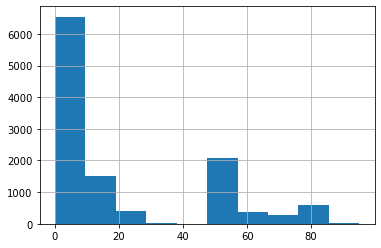

In [20]:
events_joined_total.isna().sum(axis=1).hist()

# PROD data preparation

In [21]:
def add_cumulative_sum_prod(df:pd.DataFrame, current_col_names:List[str], supl_cols) -> pd.DataFrame:
    """
    Add cumulative sum for previous fights for input columns list to input df.
    :param df: input DF (should be sorted by fighter and date)
    :param columns: Column names of the dataframe.
    :return: pd.DataFrame with cumulative sum for previous fights for input columns list.
    """
    new_cumsum_colnames = []
    df_cumulative = pd.DataFrame(index=df.index)
    for column in current_col_names:
        if 'current_' in column:
            col_name = column.replace('current_', 'cumsum_')
        else:
            col_name = 'cumsum_' + column
            
        new_cumsum_colnames.append(col_name)
        df_cumulative[col_name] = df.groupby('fighterId')[column].cumsum()
        
    df_cumulative[current_col_names+['age']] = df[current_col_names+['age']]
    df_cumulative[supl_cols] = df[supl_cols]

    return df_cumulative, new_cumsum_colnames

f_stats_events_cumulative_prod, new_cumsum_colnames = add_cumulative_sum_prod(f_stats_events_summ, current_col_names, supl_cols) # df c накопленной суммой
#count_of_fights
f_stats_events_cumulative_prod['count_of_fights'] = f_stats_events_cumulative_prod.groupby('fighterId')['fighter_nbr'].cumcount()
f_stats_events_cumulative_prod

,cumsum_duration,cumsum_winner,cumsum_hitsTotal,cumsum_hitsSuccessful,cumsum_takedownTotal,cumsum_takedownSuccessful,cumsum_submissionAttempts,cumsum_takeovers,cumsum_accentedHitsTotal,cumsum_accentedHitsSuccessful,cumsum_knockdowns,cumsum_protectionPassage,cumsum_hitsHeadTotal,cumsum_hitsHeadSuccessful,cumsum_hitsBodyTotal,cumsum_hitsBodySuccessful,cumsum_hitsLegsTotal,cumsum_hitsLegsSuccessful,cumsum_accentedHitsPositionDistanceTotal,cumsum_accentedHitsPositionDistanceSuccessful,cumsum_accentedHitsPositionClinchTotal,cumsum_accentedHitsPositionClinchSuccessful,cumsum_accentedHitsPositionParterTotal,cumsum_accentedHitsPositionParterSuccessful,cumsum_winMethods_[DEC],cumsum_winMethods_[DQ],cumsum_winMethods_[KO],cumsum_winMethods_[SUB],current_duration,winner,current_hitsTotal,current_hitsSuccessful,current_takedownTotal,current_takedownSuccessful,current_submissionAttempts,current_takeovers,current_accentedHitsTotal,current_accentedHitsSuccessful,current_knockdowns,current_protectionPassage,current_hitsHeadTotal,current_hitsHeadSuccessful,current_hitsBodyTotal,current_hitsBodySuccessful,current_hitsLegsTotal,current_hitsLegsSuccessful,current_accentedHitsPositionDistanceTotal,current_accentedHitsPositionDistanceSuccessful,current_accentedHitsPositionClinchTotal,current_accentedHitsPositionClinchSuccessful,current_accentedHitsPositionParterTotal,current_accentedHitsPositionParterSuccessful,current_winMethods_[DEC],current_winMethods_[DQ],current_winMethods_[KO],current_winMethods_[SUB],age,eventDate.date,fighterId,fighter_nbr,odds,winnerId,count_of_fights
5253,300.0,1,66,38,0,0,0,0,66,38,0,0,42,16,8,6,16,16,66,38,0,0,0,0,1,0,0,0,300.0,True,66,38,0,0,0,0,66,38,0,0,42,16,8,6,16,16,66,38,0,0,0,0,1,0,0,0,28.0,2019-10-18 00:00:01,1,2,1.70,1.0,0
5341,600.0,1,102,47,0,0,0,0,102,47,0,0,72,20,9,6,21,21,102,47,0,0,0,0,2,0,0,0,300.0,False,36,9,0,0,0,0,36,9,0,0,30,4,1,0,5,5,36,9,0,0,0,0,1,0,0,0,28.0,2019-12-21 00:00:07,1,2,5.50,103.0,1
5517,761.0,2,124,62,0,0,0,0,124,62,0,0,84,26,11,8,29,28,123,61,0,0,1,1,2,0,1,0,161.0,True,22,15,0,0,0,0,22,15,0,0,12,6,2,2,8,7,21,14,0,0,1,1,0,0,1,0,28.0,2020-06-27 00:00:03,1,2,NaN,1.0,2
5564,917.0,3,160,90,0,0,0,0,160,90,0,0,104,38,17,14,39,38,147,80,0,0,13,10,2,0,2,0,156.0,True,36,28,0,0,0,0,36,28,0,0,20,12,6,6,10,10,24,19,0,0,12,9,0,0,1,0,28.0,2020-07-25 00:00:04,1,2,NaN,1.0,3
5729,1217.0,3,215,119,0,0,0,0,215,119,0,0,134,45,20,15,61,59,201,109,1,0,13,10,3,0,2,0,300.0,False,55,29,0,0,0,0,55,29,0,0,30,7,3,1,22,21,54,29,1,0,0,0,1,0,0,0,29.0,2020-11-07 00:00:09,1,1,1.29,277.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5807,240.0,0,11,7,0,0,0,0,8,4,0,0,7,3,0,0,1,1,6,3,2,1,0,0,0,0,0,1,240.0,False,11,7,0,0,0,0,8,4,0,0,7,3,0,0,1,1,6,3,2,1,0,0,0,0,0,1,28.0,2021-01-20 00:00:07,3667,1,4.75,353.0,0
5888,271.0,0,42,13,0,0,0,0,40,12,0,0,29,4,6,3,5,5,37,9,3,3,0,0,0,0,1,0,271.0,False,42,13,0,0,0,0,40,12,0,0,29,4,6,3,5,5,37,9,3,3,0,0,0,0,1,0,32.0,2021-03-13 00:00:06,3677,1,NaN,666.0,0
5886,300.0,0,71,13,0,0,0,0,71,13,0,0,61,9,8,3,2,1,68,11,3,2,0,0,1,0,0,0,300.0,False,71,13,0,0,0,0,71,13,0,0,61,9,8,3,2,1,68,11,3,2,0,0,1,0,0,0,26.0,2021-03-13 00:00:04,3678,2,NaN,412.0,0
5901,300.0,1,64,47,1,1,0,2,23,8,0,1,19,5,1,0,3,3,23,8,0,0,0,0,1,0,0,0,300.0,True,64,47,1,1,0,2,23,8,0,1,19,5,1,0,3,3,23,8,0,0,0,0,1,0,0,0,51.0,2021-03-20 00:00:08,3679,2,3.40,3679.0,0


In [22]:
### Calculate accuracy cols
for_accuracy_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 'accentedHitsPositionDistance', 
 'accentedHitsPositionClinch', 'accentedHitsPositionParter']
new_accuracy_cols = []
for col in for_accuracy_cols:
    new_accuracy_col = f'{col}_accuracy' 
    
    new_accuracy_cols.append(new_accuracy_col)
    f_stats_events_cumulative_prod[new_accuracy_col] = f_stats_events_cumulative_prod[f'cumsum_{col}Successful']/f_stats_events_cumulative_prod[f'cumsum_{col}Total']

    
### Calculate winpersent cols
for_percent_cols = ['DEC', 'DQ', 'KO', 'SUB']
new_percent_cols = []
for col in for_percent_cols:
    new_percent_col = f'{col}_percent' 
    new_percent_cols.append(new_percent_col)
    f_stats_events_cumulative_prod[new_percent_col] = f_stats_events_cumulative_prod[f'cumsum_winMethods_[{col}]']/f_stats_events_cumulative_prod['cumsum_winner']


### Calculate Per minute cols
for_PM_cols = ['hits', 'takedown', 'accentedHits', 'hitsHead', 'hitsBody', 'hitsLegs', 
               'accentedHitsPositionDistance', 'accentedHitsPositionClinch', 'accentedHitsPositionParter']

new_PM_cols = []
for col in for_PM_cols:
    new_PM_col = f'{col}_PM' 
    new_PM_cols.append(new_PM_col)
    f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod[f'cumsum_{col}Successful']/f_stats_events_cumulative_prod['cumsum_duration']*60

    
# knockdowns per minute
new_PM_col = 'knockdowns_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod['cumsum_knockdowns']/f_stats_events_cumulative_prod['cumsum_duration']*60


# protectionPassage per minute
new_PM_col = 'protectionPassage_PM' 
new_PM_cols.append(new_PM_col)
f_stats_events_cumulative_prod[new_PM_col]  = f_stats_events_cumulative_prod['cumsum_protectionPassage']/f_stats_events_cumulative_prod['cumsum_duration']*60


# Win and Loose streak
def calculate_win_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        streaks.append(0)
        
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'
        streaks.append(0)

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values[:-1]:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1

            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['win_streak'] = win_streaks
f_stats_events_cumulative_prod['win_streak'] = f_stats_events_cumulative_prod['win_streak'] #- f_stats_events_cumulative_prod['winner']

loose_streaks = calculate_loose_streak(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['loose_streak'] = loose_streaks
f_stats_events_cumulative_prod['loose_streak'] = f_stats_events_cumulative_prod['loose_streak'] #- ~f_stats_events_cumulative_prod['winner']

new_streak_cols = ['win_streak', 'loose_streak']

current_col_names,  new_PM_cols, new_accuracy_cols, new_percent_cols, new_streak_cols

  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/2140 [00:00<?, ?it/s]

(['current_duration',
  'winner',
  'current_hitsTotal',
  'current_hitsSuccessful',
  'current_takedownTotal',
  'current_takedownSuccessful',
  'current_submissionAttempts',
  'current_takeovers',
  'current_accentedHitsTotal',
  'current_accentedHitsSuccessful',
  'current_knockdowns',
  'current_protectionPassage',
  'current_hitsHeadTotal',
  'current_hitsHeadSuccessful',
  'current_hitsBodyTotal',
  'current_hitsBodySuccessful',
  'current_hitsLegsTotal',
  'current_hitsLegsSuccessful',
  'current_accentedHitsPositionDistanceTotal',
  'current_accentedHitsPositionDistanceSuccessful',
  'current_accentedHitsPositionClinchTotal',
  'current_accentedHitsPositionClinchSuccessful',
  'current_accentedHitsPositionParterTotal',
  'current_accentedHitsPositionParterSuccessful',
  'current_winMethods_[DEC]',
  'current_winMethods_[DQ]',
  'current_winMethods_[KO]',
  'current_winMethods_[SUB]'],
 ['hits_PM',
  'takedown_PM',
  'accentedHits_PM',
  'hitsHead_PM',
  'hitsBody_PM',
  'hitsLe

In [23]:
# Win and Loose streak
def calculate_win_streak_prod(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'eventDate.date'
        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values:
            
            if fighterId == winnerId:
                curr_streak += 1
            else:
                curr_streak = 0

            streaks.append(curr_streak)

    return streaks

def calculate_loose_streak_prod(df):
    streaks = []
    for fighter in tqdm(df[:].groupby(['fighterId'])): #, 'fighter_nbr'

        curr_streak = 0
        fighterId = fighter[0]
        for winnerId in fighter[1][['winnerId']].values:
            if fighterId == winnerId:
                curr_streak = 0
            else:
                curr_streak += 1
            streaks.append(curr_streak)

    return streaks

win_streaks = calculate_win_streak_prod(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['win_streak'] = win_streaks
f_stats_events_cumulative_prod['win_streak'] = f_stats_events_cumulative_prod['win_streak'] #- f_stats_events_cumulative_prod['winner']

loose_streaks = calculate_loose_streak_prod(f_stats_events_cumulative_prod)
f_stats_events_cumulative_prod['loose_streak'] = loose_streaks
f_stats_events_cumulative_prod['loose_streak'] = f_stats_events_cumulative_prod['loose_streak'] #- ~f_stats_events_cumulative_prod['winner']

new_streak_cols = ['win_streak', 'loose_streak']

  0%|          | 0/2140 [00:00<?, ?it/s]

  0%|          | 0/2140 [00:00<?, ?it/s]

In [24]:
f_stats_events_cumulative_prod['fighterName'] = f_stats_events_cumulative_prod['fighterId'].replace(f_name_dict)
f_stats_events_cumulative_prod.to_csv('./data_models/PROD_f_stats_events_cumulative_prod_08.04.2021.csv')